| $k~[h/{\rm Mpc}]$ | Approx. mass scale $M(k) [M_\odot/h]$ | Corresponding structure    |
| ----------------: | ------------------------------------: | -------------------------- |
|               0.1 |                   $3.6\times10^{15}$| cluster scales             |
|                 1 |                   $3.6\times10^{12}$| $L_*$ galaxy halo          |
|                10 |                   $3.6\times10^{9}$| dwarf / small subhalo      |
|               100 |                   $3.6\times10^{6}$| very small DM subhalo      |
|              1000 |                   $3.6\times10^{3}$| Earth-mass microhalo scale |


In [104]:
import numpy as np
import matplotlib.pyplot as plt

In [105]:
from colossus.cosmology import cosmology as colossus_cosmo

from DES_analysis import *
c = cosmology()

In [106]:
zmin=0.15
zmax=6.0
kmin=1e-1
kmax=1e3
n=256

k_grid = np.logspace(np.log10(kmin), np.log10(kmax), n)*c.h 
z_grid = np.linspace(0,zmax,n)

In [107]:
WMAP9 = colossus_cosmo.setCosmology('WMAP9')
cosmo = colossus_cosmo.getCurrent()
Pk_WMAP9 = cosmo.matterPowerSpectrum(k_grid)

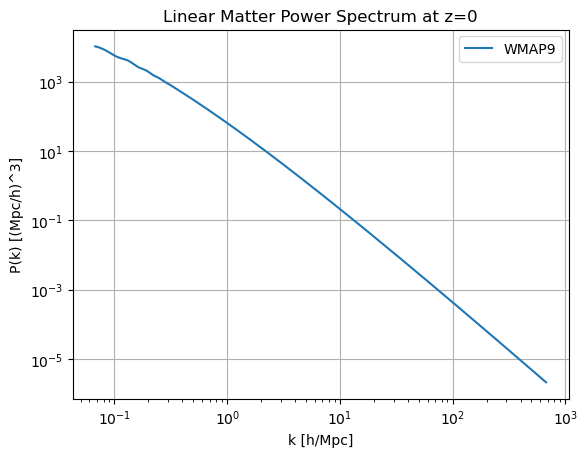

In [108]:
plt.loglog(k_grid, Pk_WMAP9,label='WMAP9')
plt.legend()    
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k) [(Mpc/h)^3]')
plt.title('Linear Matter Power Spectrum at z=0')
plt.grid()
plt.show()

In [109]:
M = np.logspace(9.0, 15, n)

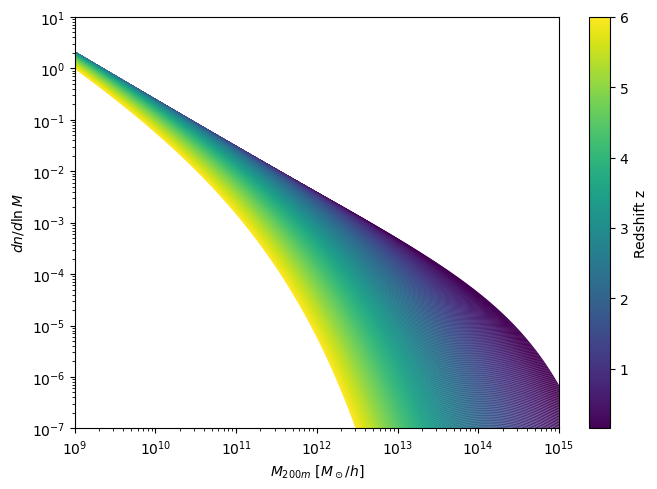

In [110]:
from colossus.lss import mass_function
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel(r'$M_{200m}\ [M_\odot/h]$')
ax.set_ylabel(r'$dn/d\ln M$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1E9, 1E15)
ax.set_ylim(1E-7, 1E1)

cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

for z in z_grid:
    mfunc = mass_function.massFunction(M, z, mdef='200m', model='tinker08', q_out='dndlnM')
    ax.plot(M, mfunc, color=cmap(norm(z)), lw=0.8)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])   
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.tight_layout()
plt.show()

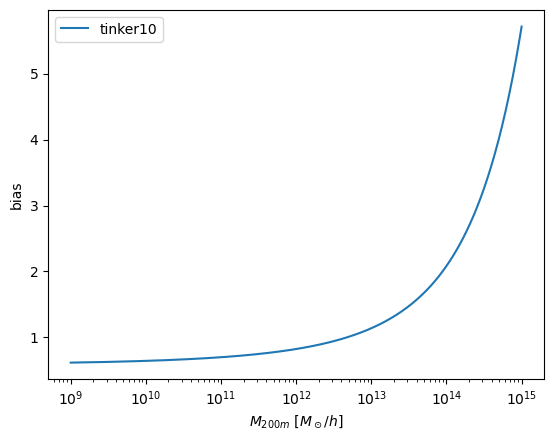

In [111]:
from colossus.lss import bias

z = 0.0 # Bias is independent from z!
mdef = '200m'

plt.figure()
plt.xlabel(r'$M_{200m}\ [M_\odot/h]$')
plt.ylabel('bias')
plt.xscale('log')
plt.plot(M,bias.haloBias(M, z, mdef, model = 'tinker10'),label='tinker10')
plt.legend()

# Fourier Transform of the NFW Profile (M₍₂₀₀₎ Convention)

For a spherical NFW density profile,

$$
\rho(r) = \frac{\rho_s}{(r/r_s)\,(1 + r/r_s)^2},
$$

with scale radius $r_s$ and concentration $c = r_{200}/r_s$, the total mass inside $r_{200}$ is

$$
M_{200} = 4\pi \rho_s r_s^3 \left[\ln(1 + c) - \frac{c}{1 + c}\right].
$$

---

## Normalized Fourier Transform

The **mass-normalized** Fourier-space profile is defined as

$$
u(k|M_{200}) = \frac{1}{M_{200}} \int_0^{r_{200}} 4\pi r^2
\frac{\sin(kr)}{kr}\,\rho(r)\,dr,
$$

which has the analytic expression (Cooray & Sheth 2002; Scoccimarro et al. 2001):

$$
u(k|M_{200}) =
\frac{1}{\ln(1 + c) - \dfrac{c}{1 + c}}
\Bigg[
\cos(kr_s)\big[\mathrm{Ci}((1 + c)kr_s) - \mathrm{Ci}(kr_s)\big]
+ \sin(kr_s)\big[\mathrm{Si}((1 + c)kr_s) - \mathrm{Si}(kr_s)\big]
- \frac{\sin(c\,kr_s)}{(1 + c)\,kr_s}
\Bigg],
$$

where

$$
\mathrm{Si}(x) = \int_0^x \frac{\sin t}{t}\,dt, \quad
\mathrm{Ci}(x) = -\int_x^\infty \frac{\cos t}{t}\,dt.
$$

This function is **dimensionless and normalized** such that $u(k \to 0) = 1$.

In [112]:
from scipy import special

def u_nfw_k(k, r_s, c):
    """
    Normalized Fourier transform u(k|M_200) of an NFW halo.
    
    Parameters
    ----------
    k : float or array_like
        Wavenumber (same inverse length unit as r_s, e.g. h/Mpc if r_s in Mpc/h)
    r_s : float
        NFW scale radius (Mpc/h)
    c : float
        Concentration parameter (r_200 / r_s)
    
    Returns
    -------
    u : array_like
        Normalized Fourier-space NFW profile (u(0)=1).
    """
    k = np.atleast_1d(k).astype(float)
    x = k * r_s
    denom = np.log(1.0 + c) - c / (1.0 + c)
    
    # sine and cosine integrals
    Si_x, Ci_x = special.sici(x)
    Si_xc, Ci_xc = special.sici((1.0 + c) * x)
    
    u = (np.cos(x) * (Ci_xc - Ci_x)
         + np.sin(x) * (Si_xc - Si_x)
         - np.sin(c * x) / ((1.0 + c) * x)) / denom

    # handle x -> 0 limit safely
    small = (x < 1e-6)
    u[small] = 1.0

    return u if u.size > 1 else u.item()

In [113]:
from sashimi_c import halo_model
hm = halo_model()

def u_nfw(k_grid,m,z):
    c200 = hm.conc200(m,z=z)
    r200  = (3.0*m/(4*np.pi*200*c.rhocrit0*c.growth_factor(z=z)))**(1./3.)
    rs    = r200/c200
    return u_nfw_k(k_grid, rs, c200)

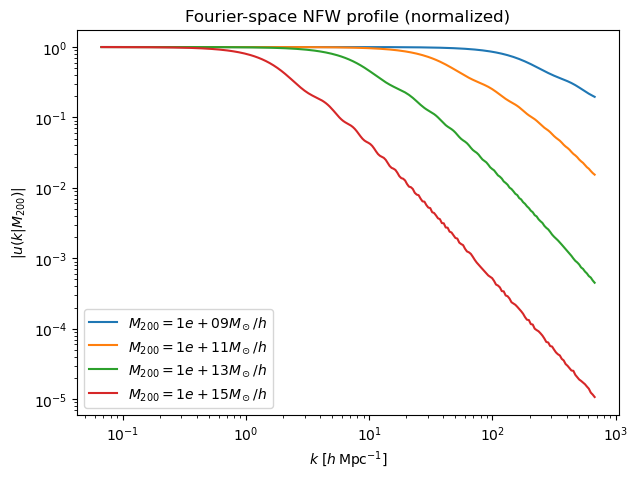

In [114]:
m_list = 10**np.array([9,11,13,15])

fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel(r'$k\ [h\,{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$|u(k|M_{200})|$')
ax.set_title('Fourier-space NFW profile (normalized)')
for m in m_list:
    u = u_nfw(k_grid, m,z=0)
    ax.loglog(k_grid, np.abs(u), label=f'$M_{{200}}={m:.0e} M_\\odot/h$')
ax.legend()
plt.show()

$\bar{\rho} = \int M n(M) dM$

In [115]:
from colossus.lss import mass_function
from scipy.integrate import simpson

dndlnM = mass_function.massFunction(M, z=0, mdef='200m', model='tinker08', q_out='dndlnM')
rho = simpson(M * dndlnM, np.log(M))

rho_cosmo = c.rhocrit0*c.OmegaM
print(f'Cosmological mean matter density: rho_m = {rho_cosmo:.3e} M_sun/h/(Mpc/h)^3')
print(f'Mean matter density from mass function integration: rho_bar = {rho:.3e} M_sun/h/(Mpc/h)^3')

Cosmological mean matter density: rho_m = 3.973e+10 M_sun/h/(Mpc/h)^3
Mean matter density from mass function integration: rho_bar = 4.529e+10 M_sun/h/(Mpc/h)^3


In [116]:
rho = rho_cosmo

In [157]:
z_list = np.linspace(0.0,6.0,10)
z_grid = z_list

In [158]:
P_1h = np.zeros((len(k_grid), len(z_grid)))
def integrand(M, k, z):
    dndlnM = mass_function.massFunction(M, z, mdef='200m', model='tinker08', q_out='dndlnM')
    return ( M / rho ) **2 * dndlnM * u_nfw(k, M,z)**2

for i, z in enumerate(z_grid):
    for j, k in enumerate(k_grid):
        
        integrand_values = integrand(M, k, z)
        P_1h[j,i] = simpson(integrand_values, np.log(M))    

In [159]:
from colossus.lss import bias


P_2h = np.zeros((len(k_grid), len(z_grid)))
def integrand_2h(M, k, z):
    b = bias.haloBias(M, z, '200m', model = 'tinker10')
    Plin = cosmo.matterPowerSpectrum(k,z)
    dndlnM = mass_function.massFunction(M, z, mdef='200m', model='tinker08', q_out='dndlnM')
    return Plin * ( ( M / rho ) * dndlnM  * b * u_nfw(k, M,z) ) ** 2

for i, z in enumerate(z_grid):
    for j, k in enumerate(k_grid):
        
        integrand_values = integrand_2h(M, k, z)
        P_2h[j,i] = simpson(integrand_values, np.log(M))**2 * cosmo.matterPowerSpectrum(k,z=z)

In [160]:
np.savez('halo_model_power_spectra.npz', k=k_grid, z=z_grid, P_1h=P_1h, P_2h=P_2h)

In [161]:
P_1h = np.load('halo_model_power_spectra.npz')['P_1h']
P_2h = np.load('halo_model_power_spectra.npz')['P_2h']

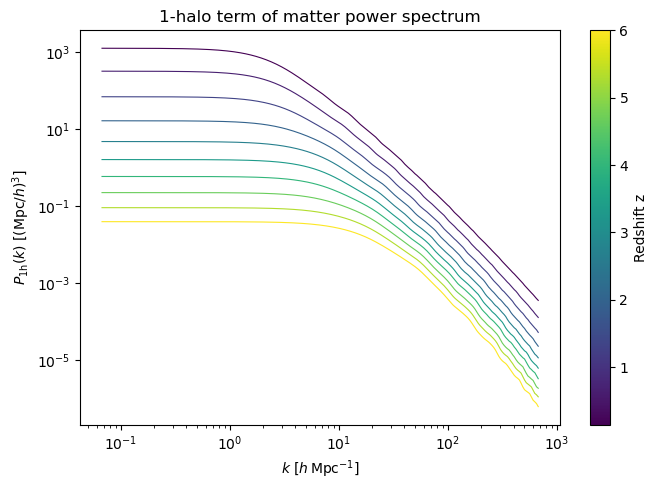

In [162]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel(r'$k\ [h\,{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{\rm 1h}(k)$ [$(\mathrm{Mpc}/h)^3$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('1-halo term of matter power spectrum')

# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

# Plot each redshift with corresponding color
for i, z in enumerate(z_grid):
    ax.plot(k_grid, P_1h[:, i], color=cmap(norm(z)), lw=0.8)

# Add colorbar for redshift
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.tight_layout()
plt.show()

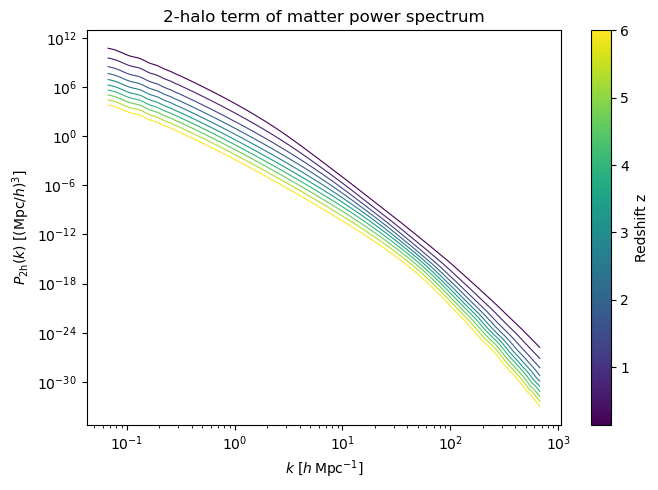

In [163]:
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel(r'$k\ [h\,{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{\rm 2h}(k)$ [$(\mathrm{Mpc}/h)^3$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('2-halo term of matter power spectrum')

# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

# Plot each redshift with corresponding color
for i, z in enumerate(z_grid):
    ax.plot(k_grid, P_2h[:, i], color=cmap(norm(z)), lw=0.8)

# Add colorbar for redshift
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.tight_layout()
plt.show()

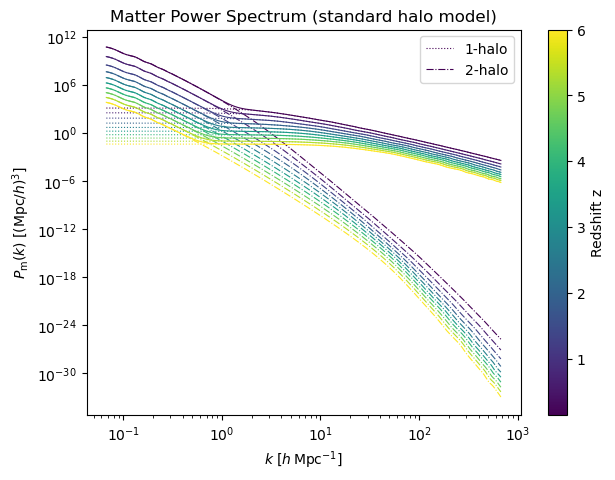

In [171]:
Pm = P_1h + P_2h

fig, ax = plt.subplots(figsize=(7,5))
ax.set_title('Matter Power Spectrum (standard halo model)')
ax.set_xlabel(r'$k\ [h\,{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{\rm m}(k)$ [$(\mathrm{Mpc}/h)^3$]')
ax.set_xscale('log')
ax.set_yscale('log')

# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

for i,z in enumerate(z_list):
    ax.plot(k_grid, Pm[:, i], color=cmap(norm(z)), lw=0.8)
    ax.plot(k_grid, P_1h[:, i], ls=':', color=cmap(norm(z)), lw=0.8, label='1-halo')
    ax.plot(k_grid, P_2h[:, i], ls='-.', color=cmap(norm(z)), lw=0.8, label='2-halo')
    if i==0:
        ax.legend()

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.show()

In [193]:
from sashimi_c import *
M = np.logspace(9.0, 15.0, 10)  #Masses at z=0
z_list = np.linspace(0.0,6.0,10)

fsh_list = np.empty((len(M), len(z_list)))
m_list = np.empty((len(M), len(z_list)),dtype=object)
dNdlnm_list = np.empty((len(M), len(z_list)),dtype=object)
weight_list = np.empty((len(M), len(z_list)),dtype=object)
m0_list = np.empty((len(M), len(z_list)),dtype=object)

for i,Mh in enumerate(M):
    for j,z in enumerate(z_list):
        print(i,j)
        obs = subhalo_observables(M0_per_Msun=Mh,redshift=z,M0_at_redshift=False)
        fsh_list[i,j] = obs.mass_fraction(evolved=True)
        m_list[i,j],dNdlnm_list[i,j] = obs.mass_function(evolved=True)
        weight_list[i,j] = obs.weight
        m0_list[i,j] = obs.m0

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


In [125]:
np.savez('subhalo_observables.npz', M=M, z=z_list, fsh=fsh_list, m_subhalo=m_list, dNdlnM_subhalo=dNdlnm_list)

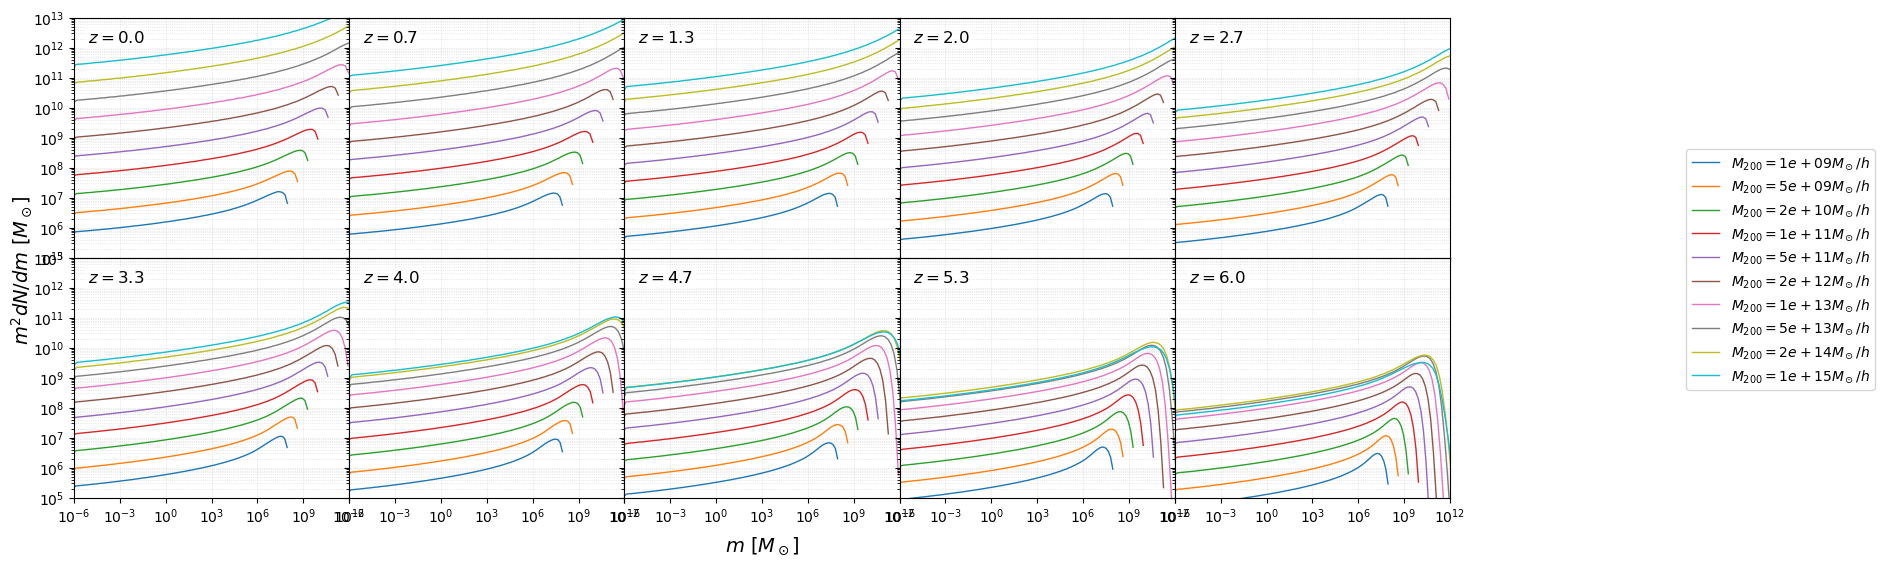

In [191]:
fig, ax = plt.subplots(
    2, 5, figsize=(16, 6),
    sharex=True, sharey=True,
    gridspec_kw={'wspace': 0, 'hspace': 0}  # subplots touch
)
ax = ax.flatten()

# Plotting
for i, z in enumerate(z_list):
    for j, Mh in enumerate(M):
        m = m_list[j, i]
        dndlnm = dNdlnm_list[j, i]
        ax[i].loglog(m, dndlnm * m, lw=1, label=f'$M_{{200}}={Mh:.0e} M_\\odot/h$')

    # Add redshift label inside the plot (top left corner)
    ax[i].text(
        0.05, 0.95, f'$z={z:.1f}$',
        transform=ax[i].transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=2)
    )

# Set limits once
for a in ax:
    a.set_xlim(1e-6, 1e12)
    a.set_ylim(1e5, 1e13)
    a.grid(True, which='both', ls=':', lw=0.5, alpha=0.5)

# Shared axis labels
fig.text(0.5, 0.03, r'$m\ [M_\odot]$', ha='center', fontsize=14)
fig.text(0.03, 0.5, r'$m^2 dN/dm\ [M_\odot]$', va='center', rotation='vertical', fontsize=14)

# Shared legend to the right
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5), fontsize=10, frameon=True)

# Tight layout for titles and labels
plt.subplots_adjust(left=0.07, right=0.93, top=0.92, bottom=0.12)

plt.show()

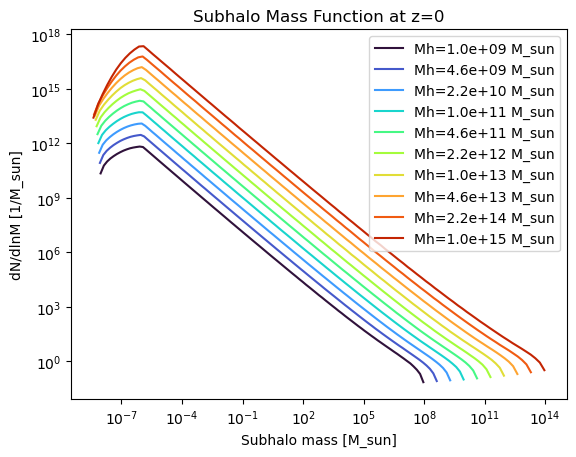

In [126]:
for i,Mh in enumerate(M):
    plt.plot(m_list[i,0],dNdlnm_list[i,0],label=f'Mh={Mh:.1e} M_sun',color=plt.cm.turbo(i/len(M)))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Subhalo mass [M_sun]')
plt.ylabel('dN/dlnM [1/M_sun]')
plt.title('Subhalo Mass Function at z=0')
plt.legend()
plt.show()

In [127]:
def I(k,z,Mh,m,dNdlnm):
    integrand_values = m/Mh * u_nfw(k, m,z) * dNdlnm
    return simpson(integrand_values,np.log(m))

In [128]:
def J(k,z,Mh,m,dNdlnm):
    integrand_values = (m/Mh)**2 *  u_nfw(k, m,z)**2 * dNdlnm
    return simpson(integrand_values,np.log(m))

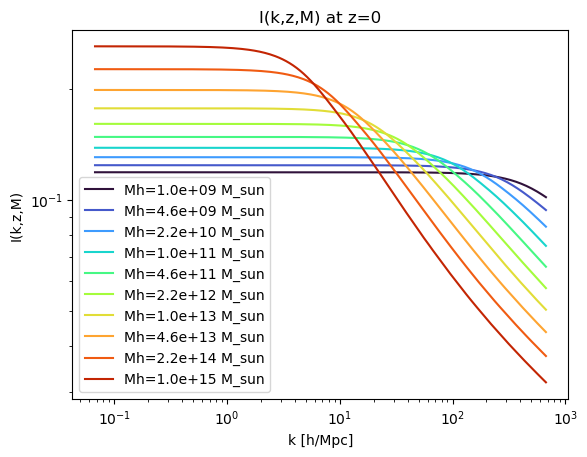

In [129]:
I_list = np.zeros((len(M),len(k_grid)))
for i,Mh in enumerate(M):
    for j,k in enumerate(k_grid):
        I_list[i,j] = I(k,0,Mh,m_list[i,0],dNdlnm_list[i,0])
    plt.plot(k_grid,I_list[i,:],label=f'Mh={Mh:.1e} M_sun',color=plt.cm.turbo(i/len(M)))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel('I(k,z,M)')
plt.title('I(k,z,M) at z=0')
plt.legend()
plt.show()

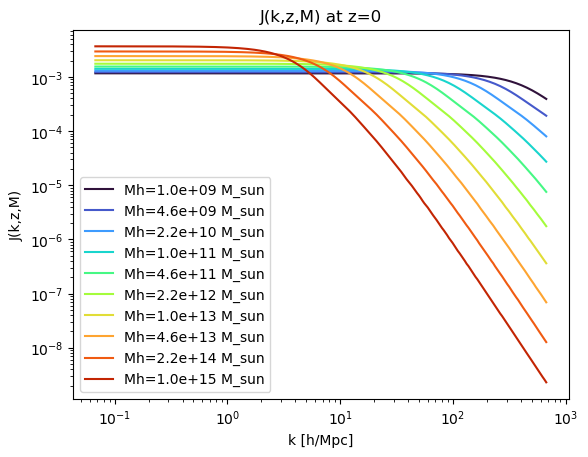

In [130]:
J_list = np.zeros((len(M),len(k_grid)))
for i,Mh in enumerate(M):
    for j,k in enumerate(k_grid):
        J_list[i,j] = J(k,0,Mh,m_list[i,0],dNdlnm_list[i,0])
    plt.plot(k_grid,J_list[i,:],label=f'Mh={Mh:.1e} M_sun',color=plt.cm.turbo(i/len(M)))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel('J(k,z,M)')
plt.title('J(k,z,M) at z=0')
plt.legend()
plt.show()

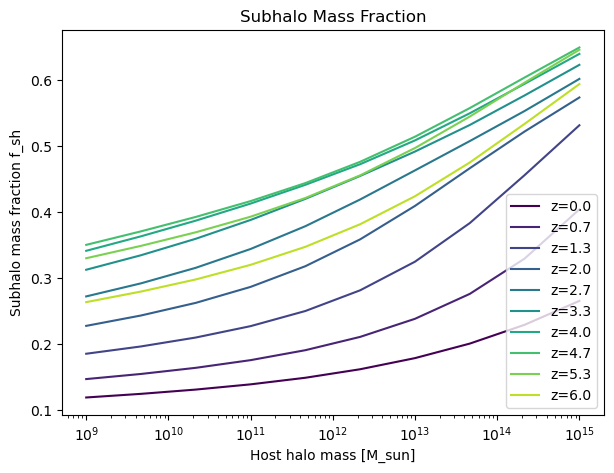

In [174]:
fig, ax = plt.subplots(figsize=(7,5))

for i,z in enumerate(z_list):
    ax.plot(M,fsh_list[:,i],label=f'z={z:.1f}',color=plt.cm.viridis(i/len(z_list)))
ax.set_xscale('log')
ax.set_xlabel('Host halo mass [M_sun]')
ax.set_ylabel('Subhalo mass fraction f_sh')
ax.set_title('Subhalo Mass Fraction')
ax.legend()
plt.show()

In [132]:
dNdlnM_list = np.zeros((len(M), len(z_list)))

for j,z in enumerate(z_list):
    dNdlnM_list[:,j] = mass_function.massFunction(M, z, mdef='200m', model='tinker08', q_out='dndlnM')

In [211]:
P_1ss = np.zeros((len(k_grid), len(z_list)))
def integrand_ss(M, k, z,i):
    fsh = fsh_list[:,i]
    Msm = M*(1 - fsh)
    dndlnM = dNdlnM_list[:,i]
    return ( Msm / rho ) **2 * dndlnM * u_nfw(k, Msm,z)**2

for i, z in enumerate(z_list):
    for j, k in enumerate(k_grid):
        integrand_values = integrand_ss(M,k,z,i)
        P_1ss[j,i] = simpson(integrand_values, np.log(M))    

In [212]:
P_1sc = np.zeros((len(k_grid), len(z_list)))
def integrand_sc(Mh, k, z,i,l):
    fsh = fsh_list[l,i]
    Msm = Mh*(1 - fsh)
    m = m_list[l,i]
    dndlnm = dNdlnm_list[l,i]
    dndlnM = dNdlnM_list[l,i]
    return  Mh * Msm / (rho**2) * dndlnM * u_nfw(k, Mh, z) * u_nfw(k, Msm, z) * I(k,z,Mh,m,dndlnm)
  
for i, z in enumerate(z_list):
    for j, k in enumerate(k_grid):    
        integrand_values = [integrand_sc(Mh,k,z,i,l) for l,Mh in enumerate(M)]
        P_1sc[j,i] = 2*simpson(integrand_values, np.log(M))  

In [221]:
P_1cc = np.zeros((len(k_grid), len(z_list)))
def integrand_cc(Mh, k, z,i,l):
    dndlnM = dNdlnM_list[l,i]
    m = m_list[l,i]
    dndlnm = dNdlnm_list[l,i]
    return  (Mh / rho)**2 * dndlnM * u_nfw(k, Mh, z)**2 * I(k,z,Mh,m,dndlnm)**2

for i, z in enumerate(z_list):
    for j, k in enumerate(k_grid):
        integrand_values = [integrand_cc(Mh,k,z,i,l) for l,Mh in enumerate(M)]
        P_1cc[j,i] = simpson(integrand_values, np.log(M))  

In [222]:
P_1self_c = np.zeros((len(k_grid), len(z_list)))
def integrand_self_c(M, k, z,i,l):
    dndlnM = dNdlnM_list[l,i]
    m = m_list[l,i]
    dndlnm = dNdlnm_list[l,i]
    return  (M / rho)**2 * dndlnM * J(k,z,M,m,dndlnm)

for i, z in enumerate(z_list):
    for j, k in enumerate(k_grid):
        integrand_values = [integrand_self_c(Mh,k,z,i,l) for l,Mh in enumerate(M)]
        P_1self_c[j,i] = simpson(integrand_values, np.log(M))  

In [225]:
P_1h_total = P_1ss + P_1sc + P_1cc + P_1self_c
np.savez('halo_model_power_spectra_substructure.npz', k=k_grid, z=z_list, P_1ss=P_1ss, P_1sc=P_1sc, P_1cc=P_1cc, P_1self_c=P_1self_c, P_1h_total=P_1h_total)

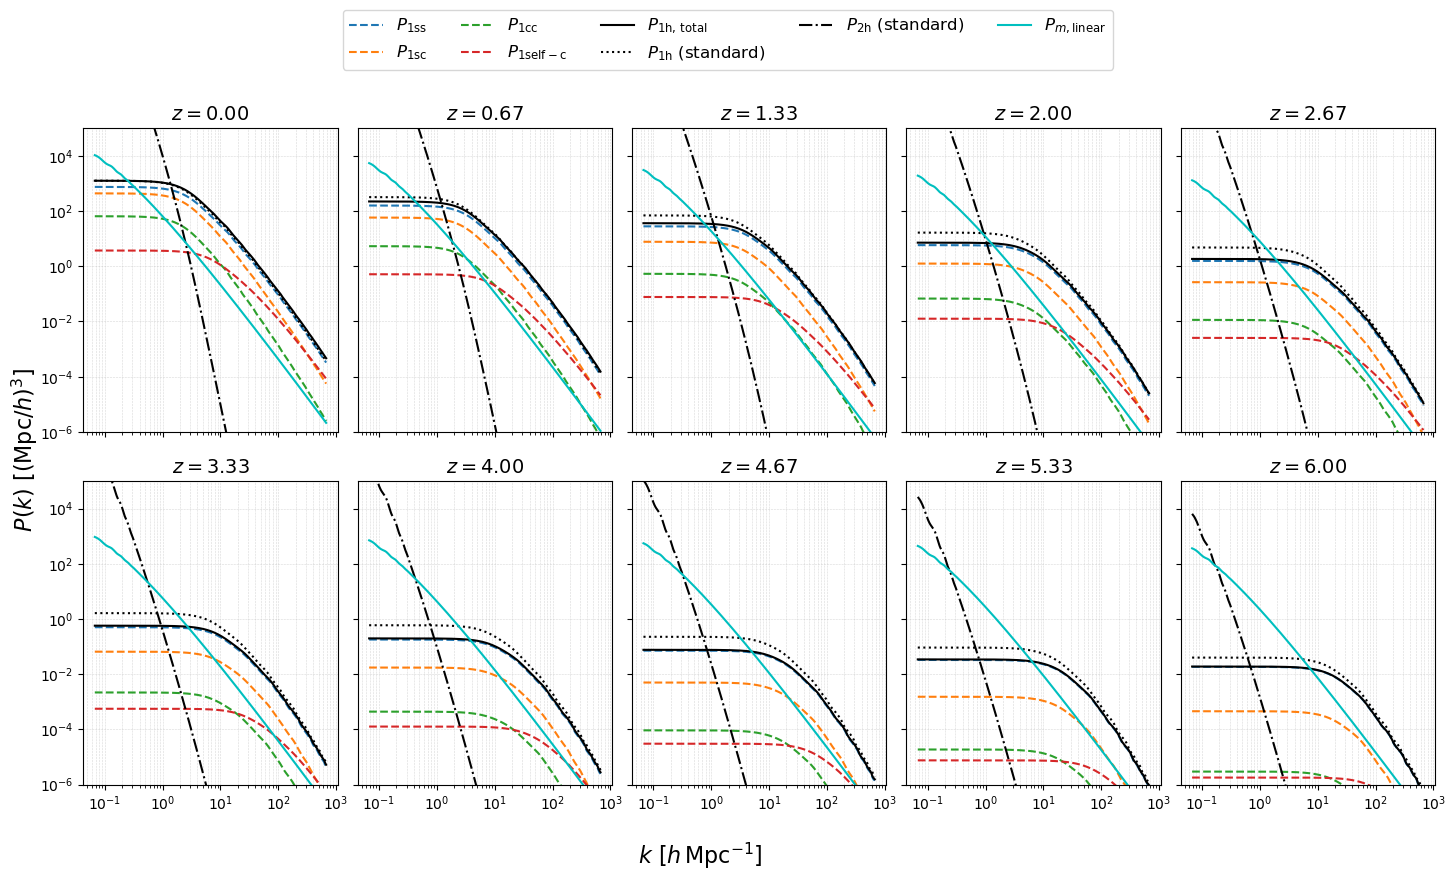

In [226]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

for i, z in enumerate(z_list):
    ax = axes[i]

    # --- Plot each 1-halo component ---
    ax.plot(k_grid, P_1ss[:, i],     color='C0', ls='--',     label=r"$P_{1\mathrm{ss}}$")
    ax.plot(k_grid, P_1sc[:, i],     color='C1', ls='--',     label=r"$P_{1\mathrm{sc}}$")
    ax.plot(k_grid, P_1cc[:, i],     color='C2', ls='--',     label=r"$P_{1\mathrm{cc}}$")
    ax.plot(k_grid, P_1self_c[:, i], color='C3', ls='--', label=r"$P_{1\mathrm{self-c}}$")

    # --- Total 1-halo ---
    ax.plot(k_grid, P_1h_total[:, i], color='black', ls='-', label=r"$P_{1\mathrm{h,\,total}}$")

    # --- standard 1-halo and 2-halo ---
    ax.plot(k_grid, P_1h[:, i], ls=':', color='black', label=r"$P_{1\mathrm{h}}$ (standard)")
    ax.plot(k_grid, P_2h[:, i], ls='-.', color='black', label=r"$P_{2\mathrm{h}}$ (standard)")

    # --- Linear power spectrum ---
    cosmo = colossus_cosmo.getCurrent()
    P_lin = np.array([cosmo.matterPowerSpectrum(k, z=z) for k in k_grid])
    ax.plot(k_grid, P_lin, ls='-', color='c', label=r"$P_{m\mathrm{,linear}}$")


    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-6, 1e5)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls="--", lw=0.4, alpha=0.5)

# --- Turn off any unused panels (none here) ---
for j in range(len(z_list), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [h\,{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
fig.text(0.04, 0.5, r"$P_{\rm}(k)\ [(\mathrm{Mpc}/h)^3]$", va="center",
         rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=0.6)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()


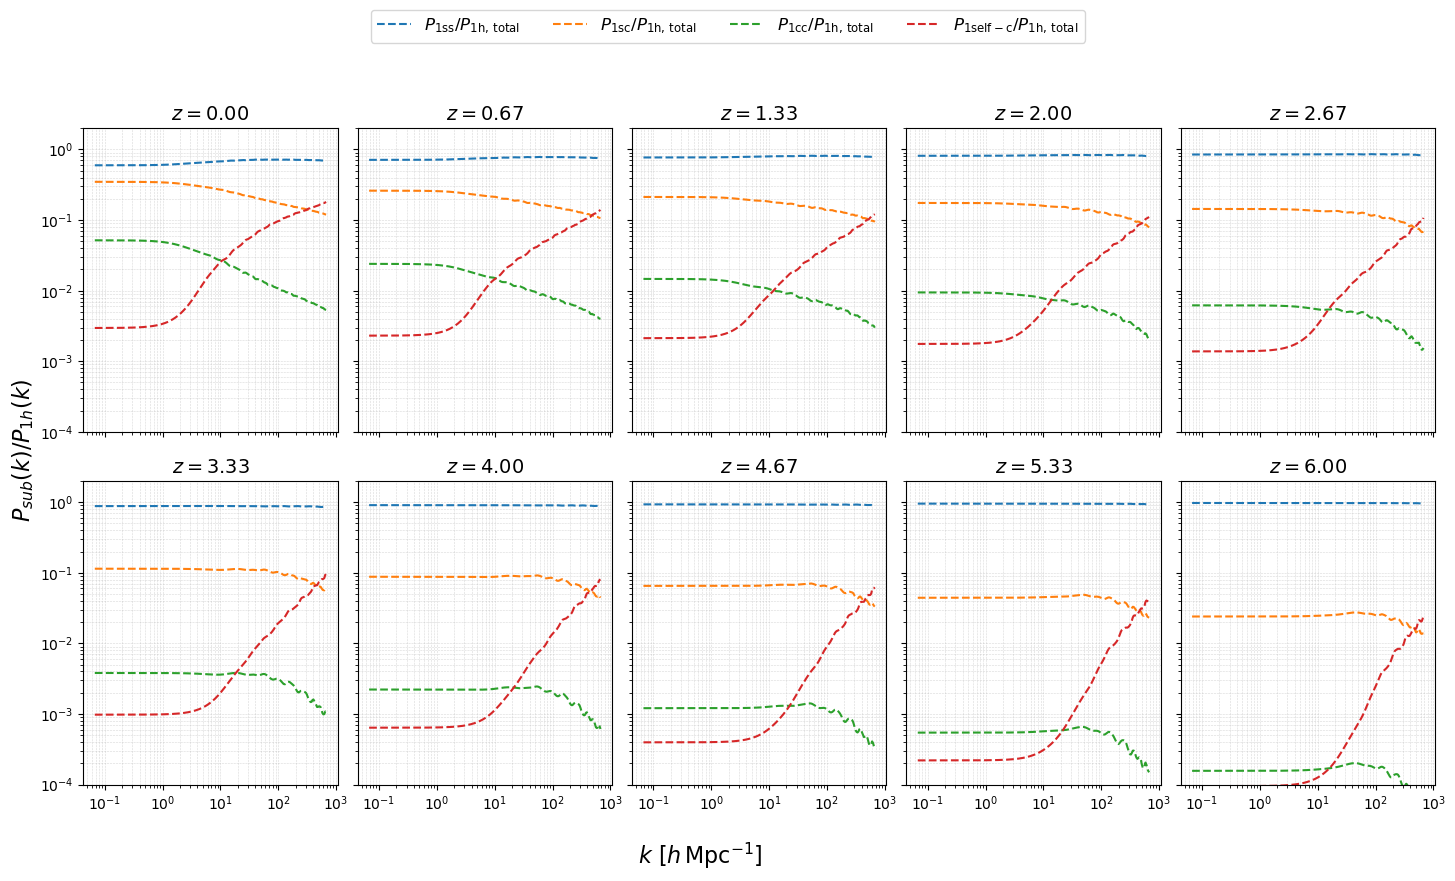

In [229]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

for i, z in enumerate(z_list):
    ax = axes[i]

    # --- Plot each 1-halo component ---
    ax.plot(k_grid, P_1ss[:, i]/P_1h_total[:, i],     color='C0', ls='--',     label=r"$P_{1\mathrm{ss}}/P_{1\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_1sc[:, i]/P_1h_total[:, i],     color='C1', ls='--',     label=r"$P_{1\mathrm{sc}}/P_{1\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_1cc[:, i]/P_1h_total[:, i],     color='C2', ls='--',     label=r"$P_{1\mathrm{cc}}/P_{1\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_1self_c[:, i]/P_1h_total[:, i], color='C3', ls='--', label=r"$P_{1\mathrm{self-c}}/P_{1\mathrm{h,\,total}}$")

    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-4, 2)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls="--", lw=0.4, alpha=0.5)

# --- Turn off any unused panels (none here) ---
for j in range(len(z_list), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [h\,{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
fig.text(0.04, 0.5, r'$P_{sub}(k) /P_{1h}(k)$', va="center",
         rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=0.6)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()